# L2 - Contextualized Token Embeddings

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>


I ran this on Google colab. Something about scipy does not work atm on my mac.

## Embedding Vectors in other domains

### Image embeddings translate visual content into a vector form. 
### Video embeddings capture the characteristics of video data, including visual appearnace and temporal dynamics. 
### Audio embeddings represent sound signals in a vector space. 

### Graph embeddings: convert nodes, edges, and their features in a graph into vector space, preserving structural information.
### shared embedding spaces: for example, CLIP which generates  embeddings for both text and images.  

#### LLMs: input tokens are converted to token embeddings
#### Semantic Search: enhances search engines by retrieving snetences with similar meanings, improving search relevance. 
#### RAG: Sentence embeddings enable efficient retrieval of relevant chunks. 
#### Recommendations: representing products in embedding space and using similarity search. 
#### Anomaly Detection: identifies patterns in data that deviate significantly from the norm. 


### Sentence Embedding: Critical for RAG. 
#### Your data + User Query --> Retrieval Engine + Fact ----> LLM 
#### User Query ----> LLM    
#### LLM ----> Response 



# Cross-Encoders for Relevance Ranking
### Question + SEP + Answer -----> Cross Encoder -----> binary 0 or 1.

#### Cross-encoder based classifier to computer question/answer relevance. 
#### Accurate but slow

# Sentence Embedding Models for relevance ranking. 

Chunking, ingest flow --> embedding model --> vector DB
User Query --> Embedding Model ---> Retrieval ---> Facts ---> LLM

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch

from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access <code>requirements.txt</code> file:</b> To access <code>requirements.txt</code> for this notebook, 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>

## GloVe word embeddings

In [3]:
import gensim.downloader as api
word_vectors = api.load('glove-wiki-gigaword-100')
#word_vectors = api.load('word2vec-google-news-300')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [4]:
word_vectors['king'].shape

(100,)

In [5]:
word_vectors['king'][:20]

array([-0.32307 , -0.87616 ,  0.21977 ,  0.25268 ,  0.22976 ,  0.7388  ,
       -0.37954 , -0.35307 , -0.84369 , -1.1113  , -0.30266 ,  0.33178 ,
       -0.25113 ,  0.30448 , -0.077491, -0.89815 ,  0.092496, -1.1407  ,
       -0.58324 ,  0.66869 ], dtype=float32)

In [6]:
# Words to visualize
words = ["king", "princess", "monarch", "throne", "crown",
         "mountain", "ocean", "tv", "rainbow", "cloud", "queen"]

# Get word vectors
vectors = np.array([word_vectors[word] for word in words])

In [23]:
# Reduce dimensions using PCA

# because these vectors are too high dimensional
# so we use PCA to find the most import factors/dimensions so that we can visualize them.
pca = PCA(n_components=2)
vectors_pca = pca.fit_transform(vectors)

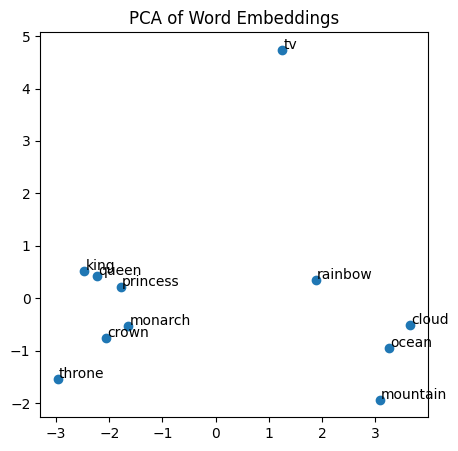

In [8]:
# Plotting
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.scatter(vectors_pca[:, 0], vectors_pca[:, 1])
for i, word in enumerate(words):
    axes.annotate(word, (vectors_pca[i, 0]+.02, vectors_pca[i, 1]+.02))
axes.set_title('PCA of Word Embeddings')
plt.show()

## Word2Vec algebra

In [9]:
result = word_vectors.most_similar(positive=['king', 'woman'],
                                   negative=['man'], topn=1)

# Output the result
print(f"""
    The word closest to 'king' - 'man' + 'woman' is: '{result[0][0]}'
    with a similarity score of {result[0][1]}""")


    The word closest to 'king' - 'man' + 'woman' is: 'queen' 
    with a similarity score of 0.7698540687561035


In [28]:
result = word_vectors.most_similar(positive=['newyork', 'buildings'],
                                   negative=['tigers'], topn=1)

# Output the result
print(f"""
    The word closest to 'newyork' - 'buildings' + 'tigers' is: '{result[0][0]}'
    with a similarity score of {result[0][1]}""")


    The word closest to 'newyork' - 'buildings' + 'tigers' is: 'platz' 
    with a similarity score of 0.4814867079257965


In [ ]:
result = word_vectors.most_similar(positive=['newyork', 'buildings'],
                                   negative=['tigers'], topn=1)

# Output the result
print(f"""
    The word closest to 'newyork' - 'buildings' + 'tigers' is: '{result[0][0]}'
    with a similarity score of {result[0][1]}""")

In [31]:
# I cannot make this stuff up :/

result = word_vectors.most_similar(positive=['paris', 'homelessness'],
                                   negative=['olympics'], topn=1)

# Output the result
print(f"""
    The word closest to 'paris' - 'homelessnes' + 'olympics' is: '{result[0][0]}'
    with a similarity score of {result[0][1]}""")


    The word closest to 'paris' - 'homelessnes' + 'olympics' is: 'alcoholism' 
    with a similarity score of 0.5355839133262634


## GloVe vs BERT: words in context

In [15]:
# tokenizer = BertTokenizer.from_pretrained('models/bert-base-uncased')
# model = BertModel.from_pretrained('models/bert-base-uncased')
# I directly downloaded from huggingface
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


# Function to get BERT embeddings
def get_bert_embeddings(sentence, word):
    inputs = tokenizer(sentence, return_tensors='pt')
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    word_tokens = tokenizer.tokenize(sentence)
    word_index = word_tokens.index(word)
    word_embedding = last_hidden_states[0, word_index + 1, :]  # +1 to account for [CLS] token
    return word_embedding

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [16]:
sentence1 = "The bat flew out of the cave at night."
sentence2 = "He swung the bat and hit a home run."

word = "bat"

bert_embedding1 = get_bert_embeddings(sentence1, word).detach().numpy()
bert_embedding2 = get_bert_embeddings(sentence2, word).detach().numpy()
word_embedding = word_vectors[word]

In [17]:
print("BERT Embedding for 'bat' in sentence 1:", bert_embedding1[:5])
print("BERT Embedding for 'bat' in sentence 2:", bert_embedding2[:5])
print("GloVe Embedding for 'bat':", word_embedding[:5])

bert_similarity = cosine_similarity([bert_embedding1], [bert_embedding2])[0][0]
word_embedding_similarity = cosine_similarity([word_embedding], [word_embedding])[0][0]

print()
print(f"Cosine Similarity between BERT embeddings in different contexts: {bert_similarity}")
print(f"Cosine Similarity between GloVe embeddings: {word_embedding_similarity}")


BERT Embedding for 'bat' in sentence 1: [ 0.4131613  -0.12908208 -0.44865727 -0.40492675 -0.15305734]
BERT Embedding for 'bat' in sentence 2: [ 0.64066994 -0.31121498 -0.44089845 -0.16551109 -0.2005611 ]
GloVe Embedding for 'bat': [-0.47601  0.81705  0.11151 -0.22687 -0.80672]

Cosine Similarity between BERT embeddings in different contexts: 0.459957480430603
Cosine Similarity between GloVe embeddings: 1.0


## Cross Encoder

In [19]:
!pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 5.9 MB/s eta 0:00:00


In [20]:
from sentence_transformers import CrossEncoder
model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', max_length=512,
                     default_activation_function=torch.nn.Sigmoid())

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [21]:
question = "Where is the capital of France?"
# Define sentences to compare
answers = [
    "Paris is the capital of France.",
    "Berlin is the capital of Germany.",
    "Madrid is the capital of Spain."
]

In [32]:
# through embeddings, you get the correct answers
scores = model.predict([(question, answers[0]), (question, answers[1]),
                        (question, answers[2])])
print(scores)
most_relevant_idx = torch.argmax(torch.tensor(scores)).item()
print(f"The most relevant passage is: {answers[most_relevant_idx]}")

[0.99965715 0.0528962  0.04520684]
The most relevant passage is: Paris is the capital of France.


In [33]:
question = "What is Paris left with if there is no homelessness but they get Olympics?"
# Define sentences to compare
answers = [
    "Someones has to get a driking problem",
    "Only great things",
    "Homelessness will come back"
]

In [34]:
# well, here you go
scores = model.predict([(question, answers[0]), (question, answers[1]),
                        (question, answers[2])])
print(scores)
most_relevant_idx = torch.argmax(torch.tensor(scores)).item()
print(f"The most relevant passage is: {answers[most_relevant_idx]}")

[1.7427175e-05 3.4823395e-05 9.6433447e-04]
The most relevant passage is: Homelessness will come back
